# Série do Tório

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import peakutils
import sys

sys.path.insert(0, "../")

from scipy.optimize import curve_fit, least_squares, fsolve, leastsq
from scipy.signal import gaussian
from scipy.ndimage import filters

from common import *

%matplotlib inline

pars_calibracao = np.array([3.8215880409588541e-05, 0.031908378390707419, 6.140984458104163])
incertezas_calibracao = np.array([2.0005452742905427e-05, 0.013574765061956408, 2.0394318835612819])

In [2]:
data_dir = "../../dados/"

background = os.path.join(data_dir, 'Thorium232_Expeosição24h.tsv')
torio = os.path.join(data_dir, 'mantaThorium232_Expeosição24h.tsv')

Neste experimento determinaremos a idade de uma manta de ${ }^{232}$Th. Utilizaremos duas aquisições: o arquivo cujo caminho esta na variável background, correspondente a uma exposição de 24 h com o detector sem nenhuma amostra, e o arquivo em torio, contendo uma exposição de 24 h da manta de Tório cuja idade será determinada.


Nossa análise procederá da seguinte forma: 

* Subtrairemos o background dos dados obtidos para o tório
* Suavizaremos os dados (fazendo uma média ponderada com pesos gaussianos)
* Calibraremos o espectro
* Selecionaremos uma janela de observação entre 825 e 1100 keV. Esta região contêm dois picos do ${}^{228}$Ac, em 911 e 969 kev, e um pico do ${}^{208}$Tl, em 860 keV.
* Ajustaremos uma função correspondente à soma de um baseline linear com três picos gaussianos

$$I(x) = ax + b + \sum_{k=1}^{3} \frac{A_k}{\sqrt{2\pi \sigma_k}} \exp\left(-\frac{(x - \mu_k)^2}{2\sigma_k^2}\right)$$

* Obteremos a intensidade das linhas do Ac na janela de observação como a integral das gaussianas centradas em $\mu_2$ e $\mu_3$ (correspondentes às linhas de 911 e 969 keV). Corrigiremos também esta intensidade pela eficiência em energia do detector, $\epsilon(E)$, dada por

$$\epsilon(E) = 62 \left(\frac{E}{240}\right)^{-1.648}$$

(esta é a eficiência relativa à eficiência em 240 keV). A intensidade da linha do Ac é dada portanto por

$$ i_{Ac} = \frac{A_2}{\epsilon(\mu_2)} + \frac{A_3}{\epsilon(\mu_3)} $$

* Obteremos dos dados padrão tabelados para o Ac228 a probabilidade de uma transição aleatória deste ocorrer na janela de observação usada, $p_{Ac}$. Estimaremos então a atividade total como

$$ I_{Ac} = \frac{i_{Ac}}{p_{Ac}} $$

* Selecionaremos uma janela de observação entre 200 e 295 keV. Esta região possui uma linha do ${}^{212}Pb$ em 240 keV.
* Ajustaremos uma função correspondente à soma de um baseline linear com um pico gaussiano

$$I(x) = ax + b + \frac{A_1}{\sqrt{2\pi\sigma_1}} \exp\left(-\frac{(x-\mu_1)^2}{2\sigma_1^2}\right)$$

* Obteremos a intensidade das linhas do Pb na janela de observação como a integral da gaussiana, corrigindo novamente pela eficiência

$$ i_{Pb} = \frac{A_1}{\epsilon(\mu_1)} $$

* Obteremos a probabilidade de uma transição do Pb ocorrer na janela de observação utilizada, $p_{Pb}$ e estimaremos a atividade total do Pb como

$$ I_{Pb} = \frac{i_{Pb}}{p_{Pb}} $$

* Estimaremos a razão entre as atividades do ${}^{228}$Ra e do ${}^{228}$Th como as razões das atividades do Actínio e do Chumbo

$$ r = \frac{I_{Ac}}{I_{Pb}} $$

* Como a razão entre as atividades do Ra e do Th teórica é dada por

$$ r(t) = \frac{1 - e^{-\lambda_B t}}{1 - 1.5 e^{-\lambda_B t} + 1.5 e^{-\lambda_C t}} $$

(onde $B$ se refere ao ${}^{228}$Ra, $C$ ao ${}^{228}$Th e $\lambda$ é a constante de decaimento) encontramos a idade da amostra encontrando a raiz da função r(t) - r.

## Gráficos dos espectros

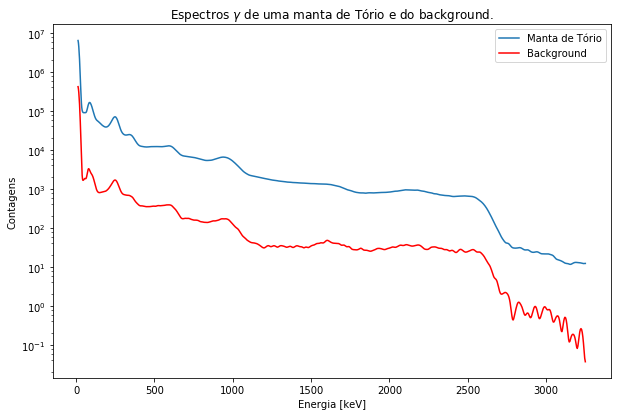

In [3]:
# Carregando dados
canais_torio, contagens_torio = load_data(torio)
canais_bkg, contagens_bkg = load_data(background)

# Suavização e calibracao
contagens_torio, contagens_bkg = smooth(contagens_torio, 3), smooth(contagens_bkg, 3)
energias = calibracao(canais_torio, pars_calibracao)

# Plota espectros
fig = plt.figure(figsize=(10, 6.5))
ax = fig.add_subplot(111)
ax.set_yscale('log')
ax.set_xlabel("Energia [keV]")
ax.set_ylabel("Contagens")
ax.set_title("Espectros $\gamma$ de uma manta de Tório e do background.")
ax.plot(energias, contagens_torio, label="Manta de Tório")
ax.plot(energias, contagens_bkg, 'r', label="Background")
_ = ax.legend()
fig.savefig("espectros_manta_bkg.pdf")

## Pico do ${}^{228}$Ac.

In [4]:
def n_picos(x, pars, a, b, n):
    """
    retorna n gaussianas somadas com baseline linear
    
    Parâmetros:
    x: np.ndarray - abscissas dos pontos a calcular
    pars: np.ndarray - parâmetros das gaussianas; pars[0:n-1] contem as médias,
            pars[n:2n -1] as amplitudes e
            pars[2n:] os desvios padrões
    a: coeficiente angular baseline
    b: coeficiente linear baseline
    n: no de picos
    """
    i, j, k = n, 0, 2*n
    y = a * x + b
    for p in range(n):
        y += pars[i + p] * mlab.normpdf(x, pars[j + p], pars[k + p])
    return y

def eficiencia(E):
    """
    Eficiência do detector na energia E, calculada segundo fórmula de (PETERSON, 1996, p. 30)
    """
    return 62 * np.power((E / 240), -1.648)

def err_eficiencia(E, dE):
    """
    Erro propagado na eficiência para energia E com incerteza dE
    """
    return 62 * 1.648 * np.power((E/240), -2.648) * dE

# Carregando dados
canais_torio, contagens_torio = load_data(torio)
canais_bkg, contagens_bkg = load_data(background)

# Subtraindo background
canais = canais_torio
contagens = contagens_torio - contagens_bkg

# Suavização e calibracao
contagens = smooth(contagens, 3)
energias = calibracao(canais, pars_calibracao)

# Janela de energias a observar picos
left_energy = 825
right_energy = 1100

# Seleção da região a observar
esta_no_pico = (energias > left_energy) & (energias < right_energy)
energias_pico = energias[esta_no_pico]
contagens_pico = contagens[esta_no_pico]
contagens_pico_bkg = contagens_bkg[esta_no_pico]

Energias: [ 861.93182723  921.          978.29788112]  +/-  [ 0.          4.39875     4.78435073]
Amplitudes: [  2.11552705e+00   1.28527447e+05   1.84630222e+05]  +/-  [  1.54921048e-08   2.58911776e+04   2.59158567e+04]
Desvios padrões: [  1.34693847e+06   3.77959367e+01   4.16450556e+01]  +/-  [  8.13345843e-12   1.29527082e+00   1.55470047e+00]
Intensidade das linhas de 911 e 969 keV do Ac-228 (c/ correção eficiência do detector):
 49188.9194134  +/-  5710.66891104


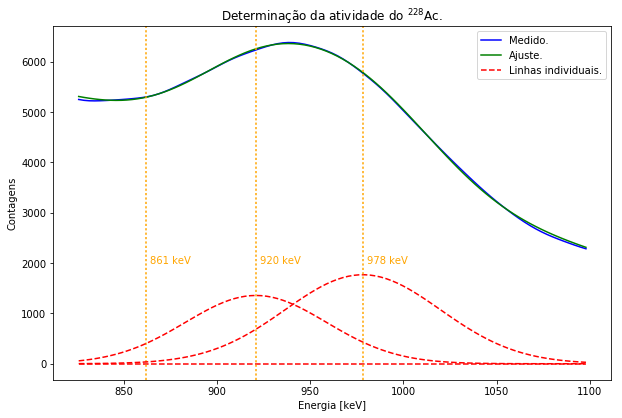

In [5]:
#No. de picos na janela de observação é 3 (picos em 860(Tl-208), 911(Ac-228) e 969 keV(Ac-228))
n = 3

#Parâmetros iniciais
x0 = [860, 911, 969]           # Energias das linhas gamma na região escolhida
x0.extend(np.ones(n) * 1000)   # Chute inicial para amplitudes de 1000
x0.extend(np.ones(n) * 100)    # Chute inicial para desvios padrões de 100

#Valores mínimos da janela de busca dos parâmetros
error_margin = 10                               # Margem de erro de 10 keV permitida nas energias
xleft = list(np.array(x0[:n]) - error_margin)   # Energias mínimas de x0 - 10 keV
xleft.extend(np.zeros(2*n))                     # Amplitudes e desvios padrões mínimos são 0

#Valores máximos da janela de busca dos parâmetros
xright = list(np.array(x0[:n]) + error_margin)  # Energias máximas de x0 + 10 keV
xright.extend(np.zeros(2*n) + np.infty)         # Amplitudes e desvios padrões máximos infinitos

#Obtêm parâmetros do baseline como reta passando pelos pontos na beirada da janela de observação dos picos
a = (contagens_pico[-1] - contagens_pico[0]) / (energias_pico[-1] - energias_pico[0])
b = contagens_pico[-1] - a * energias_pico[-1]

#res_lsq = least_squares(residue, x0,
#                        bounds = (xleft, xright),
#                        args=(energias_pico, contagens_pico, a, b, n))

def tres_picos(x, a1, a2, a3, b1, b2, b3, c1, c2, c3):
    """ Calcula três gaussianas com médias a1, a2, a3, 
    amplitudes b1, b2, b3 e desvios padrões c1, c2, c3,
    somadas ao baseline com parâmetros a e b"""
    pars = [a1, a2, a3, b1, b2, b3, c1, c2, c3]
    return n_picos(x, pars, a, b, n)

# Ajuste
pvar, pcov = curve_fit(tres_picos, energias_pico, contagens_pico, 
                       p0=x0, bounds = (xleft, xright))
# Erros no ajuste
perr = np.sqrt(np.diag(pcov))
energias_picos, err_energias_picos = pvar[:n], perr[:n]
amplitudes, err_amplitudes = pvar[n:2*n], perr[n:2*n]
std_picos, err_std_picos = pvar[2*n:], perr[2*n:]
print("Energias:", energias_picos, " +/- ", err_energias_picos)
print("Amplitudes:", amplitudes, " +/- ", err_amplitudes)
print("Desvios padrões:", std_picos, " +/- ", err_std_picos)

# Plota ajuste obtido
ajuste = n_picos(energias_pico, pvar, a, b, n)
fig = plt.figure(figsize=(10, 6.5))
ax = fig.add_subplot(111)
ax.set_xlabel("Energia [keV]")
ax.set_ylabel("Contagens")
ax.set_title("Determinação da atividade do ${}^{228}$Ac.")
_ = ax.plot(energias_pico, contagens_pico, 'b', label="Medido.")
_ = ax.plot(energias_pico, ajuste, 'g', label="Ajuste.")
for k in range(n):
    if k != n-1:
        _ = ax.plot(energias_pico, pvar[n + k] * mlab.normpdf(energias_pico, pvar[k], pvar[2*n + k]), 'r--')
    else:
        _ = ax.plot(energias_pico, pvar[n + k] * mlab.normpdf(energias_pico, pvar[k], pvar[2*n + k]), 'r--', label="Linhas individuais.")
    ax.axvline(pvar[k], linestyle=':', color='orange')
    ax.text(pvar[k] + 2, 2000, "%.3d keV" % pvar[k], color='orange')
_ = ax.legend()

# Corrige contagens das linhas do Ac-228 em 911 e 969 keV pela eficiência do detector e soma
intensidade_linhas_ac = amplitudes[1] / eficiencia(energias_picos[1]) + amplitudes[2] / eficiencia(energias_picos[2])

# Calcula erro da intensidade somada das linhas de Ac-228
err_linhas_ac = np.sqrt(
    (err_amplitudes[1] / eficiencia(energias_picos[1])) ** 2 +
    (err_amplitudes[2] / eficiencia(energias_picos[2])) ** 2 +
    err_eficiencia(energias_picos[1], err_energias_picos[1]) ** 2 + 
    err_eficiencia(energias_picos[2], err_energias_picos[2]) ** 2 
)

print("Intensidade das linhas de 911 e 969 keV do Ac-228 (c/ correção eficiência do detector):\n",
      intensidade_linhas_ac, " +/- ", err_linhas_ac)
fig.savefig("atividade_ac.pdf")

In [6]:
# Lê dados tabelados para linhas do Ac228
linhas_ac = pd.read_csv(os.path.join(data_dir, "linhas_espectrais/ac228.txt"), 
                                     sep=';', skiprows=13, skipfooter=1)

# Soma probabilidade de uma transição aleatória do Ac228 ocorrer na janela de observação utilizada
# (i.e, com energias entre left_energy e right_energy)
p_ac = linhas_ac[(linhas_ac.iloc[:,0] > left_energy) & (linhas_ac.iloc[:,0] < right_energy)].iloc[:, 2].sum()

# Obtêm intensidade total das transições do Ac228 em todas as energias
intensidade_total_ac = intensidade_linhas_ac / (p_ac / 100)
err_total_ac = err_linhas_ac / (p_ac / 100)
print("p para transições de {0} a {1} keV: {2}".format(left_energy, right_energy, p_ac))
print("Intensidade total do Ac-228: {0} +/- {1}".format(intensidade_total_ac, err_total_ac))

p para transições de 825 a 1100 keV: 52.933099999999996
Intensidade total do Ac-228: 92926.57980238688 +/- 10788.464894439518


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


## Pico do ${}^{212}$Pb

In [7]:
# Defina janela de busca para picos do Pb212
left_energy = 200
right_energy = 295

# Seleciona espectro na região da janela de busca
esta_no_pico = (energias > left_energy) & (energias < right_energy)
energias_pico = energias[esta_no_pico]
contagens_pico = contagens[esta_no_pico]
contagens_pico_bkg = contagens_bkg[esta_no_pico]

Energias: [ 248.51337118]  +/-  [ 0.14267423]
Amplitudes: [ 1660954.70216827]  +/-  [ 11314.04532058]
Desvios padrões: [ 18.19844586]  +/-  [ 0.14406155]


Intensidade da linha de 240 keV do Pb-212 (c/ correção eficiência do detector):
 28373.5958474  +/-  193.731036023


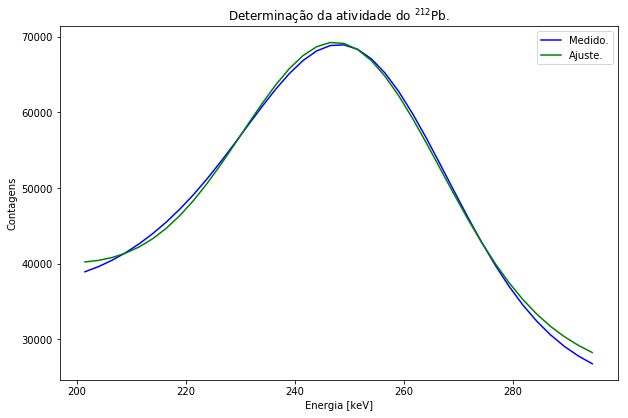

In [8]:
#No. de picos a ajustar na região: 1
n = 1

#Margem de erro na energia: 50 keV
error_margin = 50

#Parâmetros iniciais: pico em 240 keV, amplitude de 7000 e desvio padrão de 100
x0 = [240]
x0.extend(np.ones(n) * 7000)
x0.extend(np.ones(n) * 100)

#Valores mínimos dos parâmetros: energia de 240-50 keV, amplitude e desvio padrão nulo
xleft = list(np.array(x0[:n]) - error_margin)
xleft.extend(np.zeros(2*n))

#Valores máximos dos parâmetros: energia de 240+50 keV, amplitude e desvio padrão infinito
xright = list(np.array(x0[:n]) + error_margin)
xright.extend(np.zeros(2*n) + np.infty)

#Determina coeficientes do baseline como reta entre pontos nos extremos da janela de observação
a = (contagens_pico[-1] - contagens_pico[0]) / (energias_pico[-1] - energias_pico[0])
b = contagens_pico[-1] - a * energias_pico[-1]

def um_pico(x, a1, b1, c1):
    """
    Calcula um pico gaussiano com média a1, amplitude b1 e desvio padrão c1, somado ao baseline linear.
    """
    return n_picos(x, [a1, b1, c1], a, b, 1)

#Realiza ajuste
pvar, pcov = curve_fit(um_pico, energias_pico, contagens_pico,
                      p0=x0, bounds=(xleft, xright))

#Calcula erros do ajuste
perr = np.sqrt(np.diag(pcov))
energias_picos, err_energias_picos = pvar[:n], perr[:n]
amplitudes, err_amplitudes = pvar[n:2*n], perr[n:2*n]
std_picos, err_std_picos = pvar[2*n:], perr[2*n:]
print("Energias:", energias_picos, " +/- ", err_energias_picos)
print("Amplitudes:", amplitudes, " +/- ", err_amplitudes)
print("Desvios padrões:", std_picos, " +/- ", err_std_picos)

#Plota resultados
ajuste = n_picos(energias_pico, pvar, a, b, n)
fig = plt.figure(figsize=(10, 6.5))
ax = fig.add_subplot(111)
ax.set_xlabel("Energia [keV]")
ax.set_ylabel("Contagens")
ax.set_title("Determinação da atividade do ${}^{212}$Pb.")
_ = ax.plot(energias_pico, contagens_pico, 'b', label="Medido.")
_ = ax.plot(energias_pico, ajuste, 'g', label="Ajuste.")
_ = ax.legend()

# Obtêm intensidade corrigida pela eficiência do detector para a linha do Pb212
intensidade_linhas_pb = amplitudes[0] / eficiencia(energias_picos[0])

# Propaga erros
err_linhas_pb = np.sqrt(
    (err_amplitudes[0] / eficiencia(energias_picos[0])) ** 2 + 
    (err_eficiencia(energias_picos[0], err_energias_picos[0])) ** 2)

print("Intensidade da linha de 240 keV do Pb-212 (c/ correção eficiência do detector):\n",
      intensidade_linhas_pb, " +/- ", err_linhas_pb)

fig.savefig("atividade_pb.pdf")

In [9]:
# Lê dados tabelados para linhas do Pb212
linhas_pb = pd.read_csv(os.path.join(data_dir, "linhas_espectrais/pb212.txt"), 
                                     sep=';', skiprows=13, skipfooter=1)

# Soma probabilidade de uma transição aleatória do Pb212 ocorrer na janela de observação utilizada
# (i.e, com energias entre left_energy e right_energy)
p_pb = linhas_pb[(linhas_pb.iloc[:,0] > left_energy) & (linhas_pb.iloc[:,0] < right_energy)].iloc[:, 2].sum()

# Obtêm intensidade total das transições do Pb212 em todas as energias
intensidade_total_pb = intensidade_linhas_pb / (p_pb / 100)
err_total_pb = err_linhas_pb / (p_pb / 100)
print("p para transições de {0} a {1} keV: {2}".format(left_energy, right_energy, p_pb))
print("Intensidade total do Pb-212: {0} +/- {1}".format(intensidade_total_pb, err_total_pb))

p para transições de 200 a 295 keV: 43.6
Intensidade total do Pb-212: 65077.054695795436 +/- 444.33723858595266


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


In [10]:
# Calcula razão entre as atividades do Ac228 e do Pb212 (c/ erro associado)
razao_ra_th = intensidade_total_ac / intensidade_total_pb
err_razao_ra_th = np.sqrt(
    (err_total_pb / intensidade_total_pb) ** 2 + 
    (err_total_ac / intensidade_total_ac) ** 2) * razao_ra_th

print("Razão das atividades do Ra228 e do Th228: ", razao_ra_th, "+/-", err_razao_ra_th)

Razão das atividades do Ra228 e do Th228:  1.4279469198 +/- 0.166066313487


In [11]:
def razao(t):
    lc = 11.484 * 10 ** -9
    lb = 3.829 * 10 ** -9
    return (1 - np.exp(-lb * t)) / (1 - 1.5 * np.exp(-lb * b) + 1.5 * np.exp(-lc * t))

# Calcula idade em segundos da amostra encontrando raízes de razao(t) - razao_ra_th
t = fsolve(lambda t: razao_ra_th - razao(t), 365 * 24 * 3600)
t_min = fsolve(lambda t: razao_ra_th - err_razao_ra_th - razao(t), 365 * 24 * 3600)
t_max = fsolve(lambda t: razao_ra_th + err_razao_ra_th - razao(t), 365 * 24 * 3600)
print("idade mínima: {0} anos\nidade: {1} anos\nidade_máxima: {2} anos".format(
        *list(map(lambda x: x / (365 * 24 * 3600), [t_min, t, t_max]))))

idade mínima: [ 2.1739716] anos
idade: [ 2.24285216] anos
idade_máxima: [ 2.30129908] anos
